In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


llms = [ 
    "gemma3n",  
    "qwen2.5",  
    "llama3.1",  
    "orca2",  
]


examples = {
    "FIC" : "join_examples_dict_1", 
    "CIC" : 'join_examples_dict_2',
    "FSC" : 'vector_based_examples_dict_1',
    "CSC" : 'vector_based_examples_dict_2',
}

model_types = ['TF', 'FT', 'UN', 'IN']


def extract_model_type(model, suffix=""): 
    flag = True
    for ll in llms:
        if ll in model:
            flag = False
    if flag: 
        return "P1"
    elif ' U ' in model: 
        return f"UN{suffix}"
    elif ' ∩ ' in model: 
        return f"IN{suffix}"
    elif '-tf-p2' in model: 
        return "TF"
    elif '-ft-p2' in model: 
        return "FT"
    elif '-z-p2' in model: 
        return "ZS" 
    else: 
        return "P1"


def df_plot_show(groups): 
    prompt_types = list(groups.keys())
    average_f1 = list(groups.values())

    df = pd.DataFrame({"Prompt Types" : prompt_types, "Average F1" : average_f1})

    display(df.style.hide())

    # Create the bar plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(prompt_types, average_f1, alpha=0.8, edgecolor='navy', linewidth=1.2)

    # Customize the plot
    plt.title('F1 Score Averages by Prompt Type', fontsize=16, fontweight='bold')
    plt.xlabel('Prompt Types', fontsize=12)
    plt.ylabel('Average F1 Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()
    
def df_plot_show_runtime(groups): 
    prompt_types = list(groups.keys())
    average_runtime = list(groups.values())

    average_runtime_to_mmss = []
    for avg in average_runtime: 
        mm = int(avg // 60)
        ss = int(avg % 60)
        average_runtime_to_mmss.append(f"{mm:02d}:{ss:02d}")
        
    df = pd.DataFrame({"Prompt Types" : prompt_types, "Average Runtime (mm:ss)" : average_runtime_to_mmss})

    display(df.style.hide())

    # Create the bar plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(prompt_types, average_runtime, alpha=0.8, edgecolor='navy', linewidth=1.2)

    # Customize the plot
    
    # Step 4: Format y-axis ticks back to mm:ss
    def format_mmss(x, pos):
        mm = int(x // 60)
        ss = int(x % 60)
        return f"{mm:02d}:{ss:02d}"

    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_mmss))    
    
    plt.title('Average Runtime by Prompt Type', fontsize=16, fontweight='bold')
    plt.xlabel('Prompt Types', fontsize=12)
    plt.ylabel('Average Runtime (mm:ss)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        mm = int(height // 60)
        ss = int(height % 60)
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f"{mm:02d}:{ss:02d}", ha='center', va='bottom', fontweight='bold')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

    




In [7]:
def results_extraction_main(candidate_pairs): 
    datasets = ['D2', 'D5', 'D6', 'D7', 'D8']
    for dataset in datasets:
        
        print(f"Datset {dataset} table & figure")
        
        results = f'../results/{candidate_pairs}/{dataset}_clustering.csv'
        results = pd.read_csv(results)
    
        results_ui = f'../results/{candidate_pairs}/{dataset}_ui.csv'
        results_ui = pd.read_csv(results_ui)
    
        cols = ["precision","recall","f1"]
    
        for col in cols: 
            results_ui[col] = results_ui[col] * 100
    
        results_ui['model_type'] = results_ui['model'].apply(lambda x: extract_model_type(x, ""))
        results['model_type'] = results['model'].apply(lambda x: extract_model_type(x, ''))

        results = results[(results['model_type'] != 'P1') & (results['model_type'] != 'UN') & (results['model_type'] != 'IN')]  
        result_ui = results_ui[(results_ui['model_type'] != 'P1')]
        
        results = pd.concat([results, result_ui])  

        groupby = results.groupby(by=['model_type', 'examples'])



        groups = {"ZS" : groupby.get_group(("ZS", "vector_based_examples_dict_1"))['f1'].mean()}    

        for model in model_types: 
            for key in examples: 
                groups[f'{key}-{model}'] = groupby.get_group((model, examples[key]))['f1'].mean()
           

        # groups
        df_plot_show(groups)

def results_extraction_runtime(candidate_pairs): 
    datasets = ['D2', 'D5', 'D6', 'D7', 'D8']
    for dataset in datasets:
        print(f"Average Runtime Datset {dataset} table & figure")
        
        results = f'../results/{candidate_pairs}/{dataset}_clustering.csv'
        results = pd.read_csv(results)
    
        results_ui = f'../results/{candidate_pairs}/{dataset}_ui.csv'
        results_ui = pd.read_csv(results_ui)
    
        cols = ["precision","recall","f1"]
    
        for col in cols: 
            results_ui[col] = results_ui[col] * 100
    
        results_ui['model_type'] = results_ui['model'].apply(lambda x: extract_model_type(x, ""))
        results['model_type'] = results['model'].apply(lambda x: extract_model_type(x, ''))

        results = results[(results['model_type'] != 'P1') & (results['model_type'] != 'UN') & (results['model_type'] != 'IN')]  
        result_ui = results_ui[(results_ui['model_type'] != 'P1')]
        
        results = pd.concat([results, result_ui])  

        groupby = results.groupby(by=['model_type', 'examples'])



        groups = {"ZS" : groupby.get_group(("ZS", "vector_based_examples_dict_1"))['time (sec)'].mean()}    

        for model in model_types: 
            for key in examples: 
                groups[f'{key}-{model}'] = groupby.get_group((model, examples[key]))['time (sec)'].mean()
           

        # groups
        df_plot_show_runtime(groups)


Datset D2 table & figure


Prompt Types,Average F1
ZS,81.910050
FIC-TF,80.597517
CIC-TF,80.160867
FSC-TF,81.528083
CSC-TF,80.795799
FIC-FT,80.765244
CIC-FT,79.606345
FSC-FT,81.445771
CSC-FT,81.318156
FIC-UN,88.512314


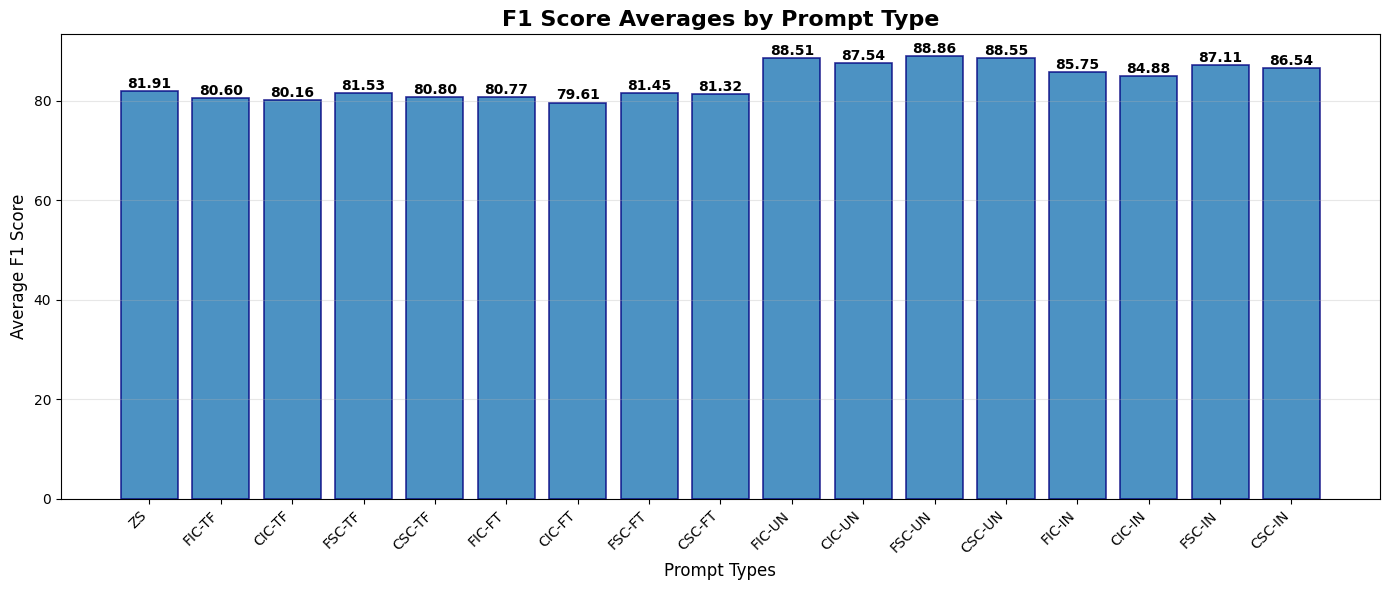

Datset D5 table & figure


Prompt Types,Average F1
ZS,76.217386
FIC-TF,71.069642
CIC-TF,79.102730
FSC-TF,79.198672
CSC-TF,77.951683
FIC-FT,63.521779
CIC-FT,77.767459
FSC-FT,76.779139
CSC-FT,78.131403
FIC-UN,75.684001


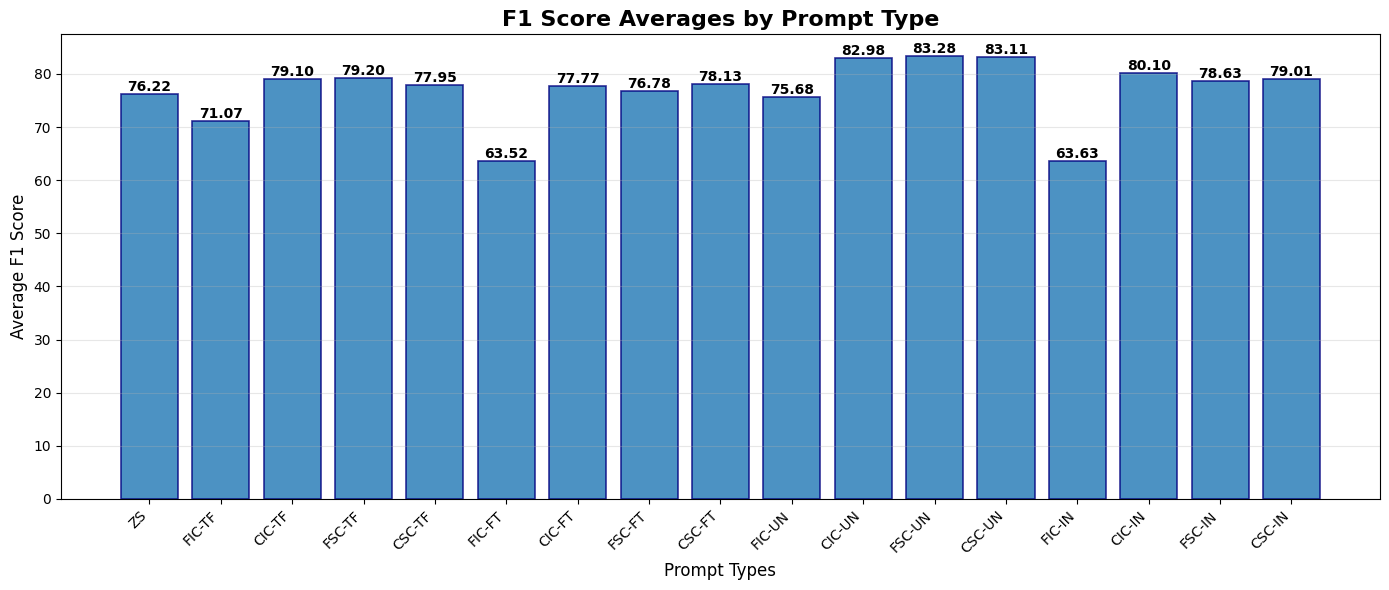

Datset D6 table & figure


Prompt Types,Average F1
ZS,64.402047
FIC-TF,64.106786
CIC-TF,64.813314
FSC-TF,60.016238
CSC-TF,61.236777
FIC-FT,62.379702
CIC-FT,64.957800
FSC-FT,60.860457
CSC-FT,64.000618
FIC-UN,68.367256


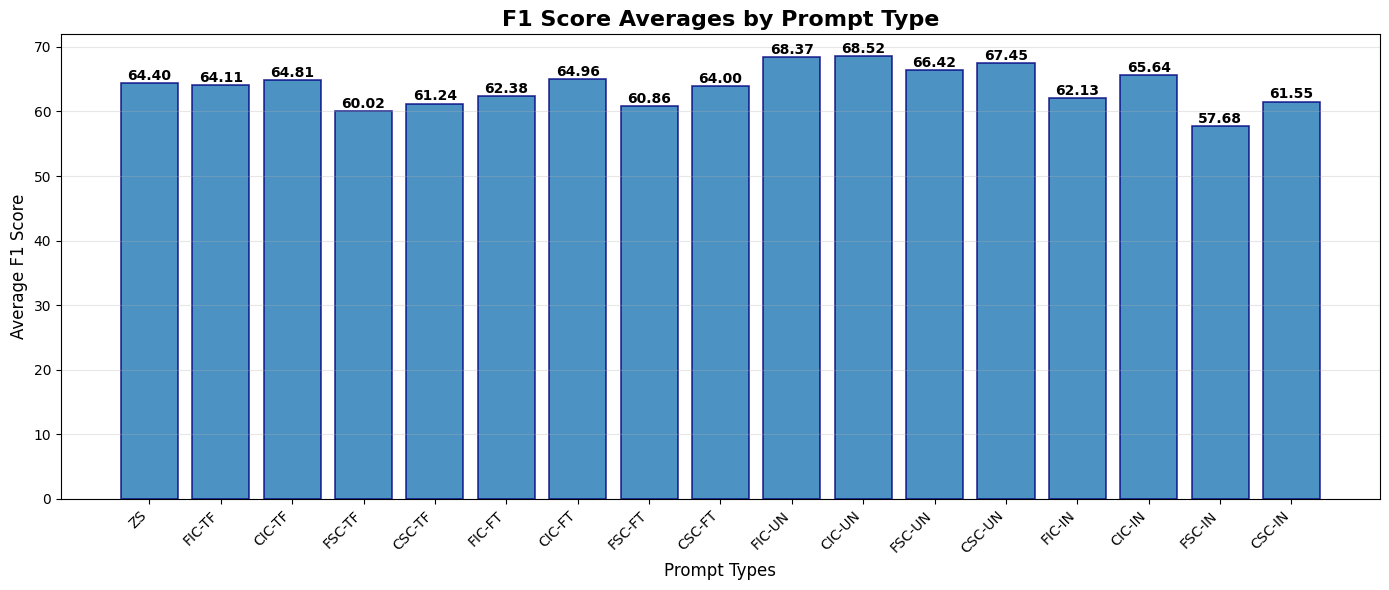

Datset D7 table & figure


Prompt Types,Average F1
ZS,60.226590
FIC-TF,60.548143
CIC-TF,60.560430
FSC-TF,59.661311
CSC-TF,59.132407
FIC-FT,61.538432
CIC-FT,62.163924
FSC-FT,60.739886
CSC-FT,59.117322
FIC-UN,61.611482


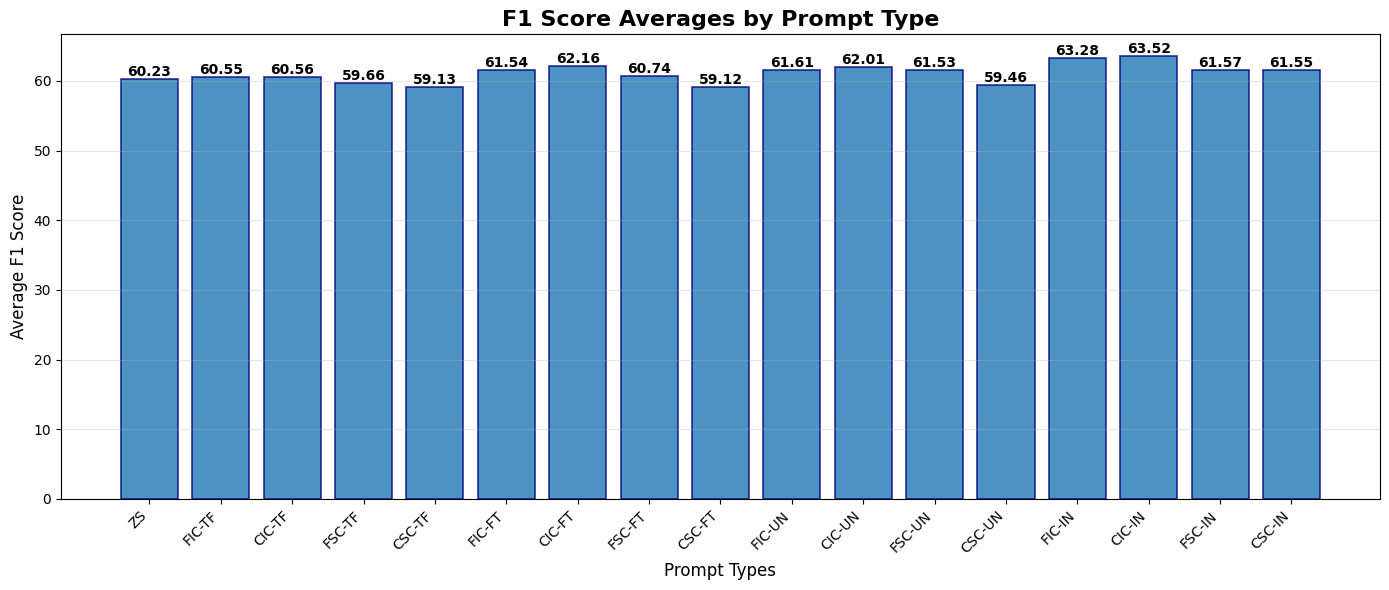

Datset D8 table & figure


Prompt Types,Average F1
ZS,53.964129
FIC-TF,51.785013
CIC-TF,50.462411
FSC-TF,53.215371
CSC-TF,49.594129
FIC-FT,50.819745
CIC-FT,50.970870
FSC-FT,51.798942
CSC-FT,50.634151
FIC-UN,54.566636


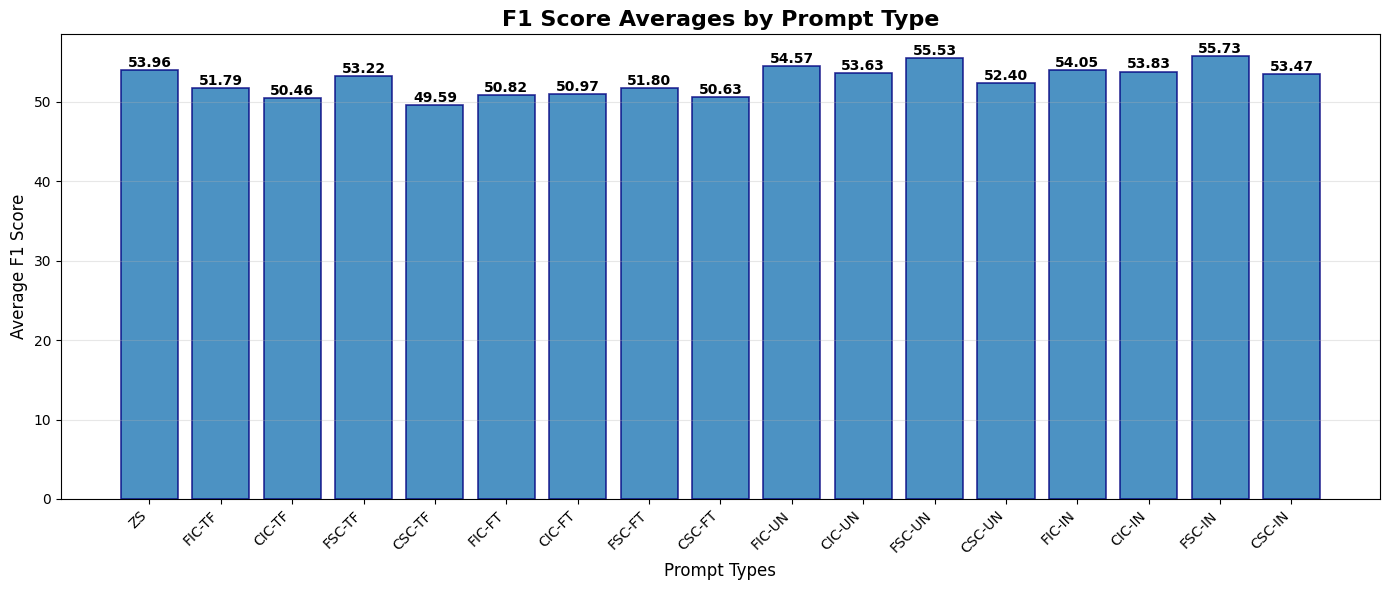

In [8]:

candidate_pairs = 'standard_blocking'
results_extraction_main(candidate_pairs)


RUNTIME
Average Runtime Datset D2 table & figure


Prompt Types,Average Runtime (mm:ss)
ZS,04:17
FIC-TF,07:27
CIC-TF,06:41
FSC-TF,04:51
CSC-TF,06:48
FIC-FT,07:31
CIC-FT,06:43
FSC-FT,04:51
CSC-FT,06:50
FIC-UN,14:59


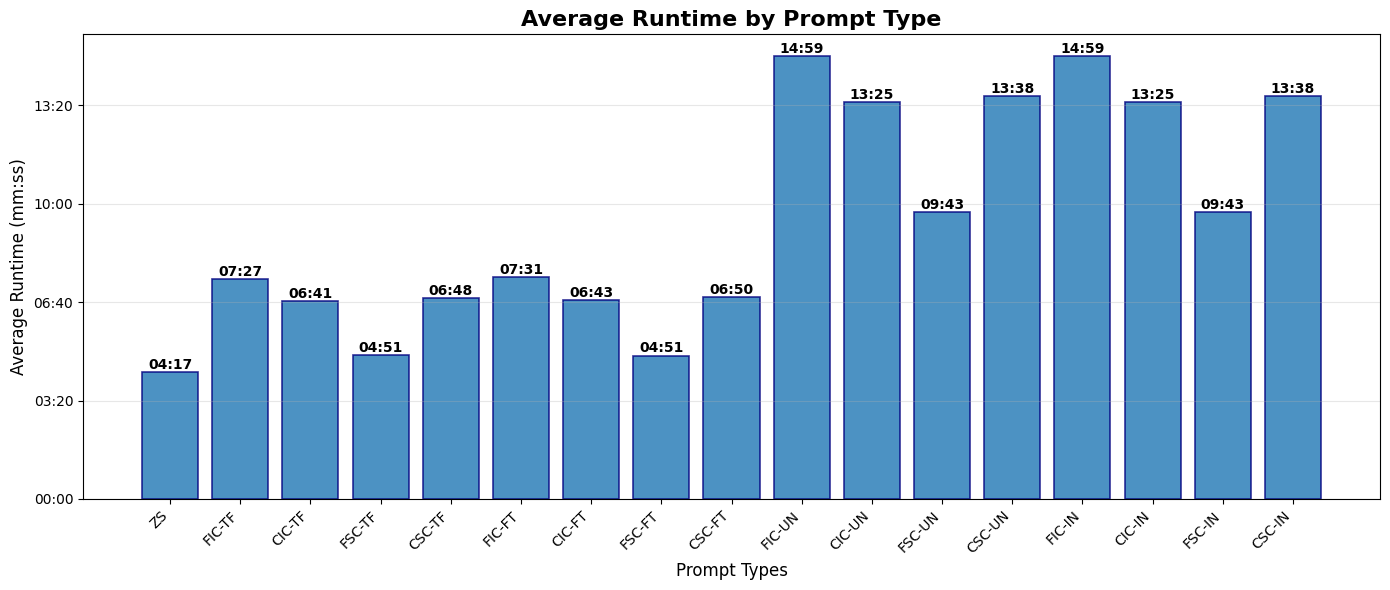

Average Runtime Datset D5 table & figure


Prompt Types,Average Runtime (mm:ss)
ZS,08:51
FIC-TF,09:59
CIC-TF,09:56
FSC-TF,10:10
CSC-TF,09:56
FIC-FT,09:58
CIC-FT,09:57
FSC-FT,10:10
CSC-FT,10:00
FIC-UN,19:57


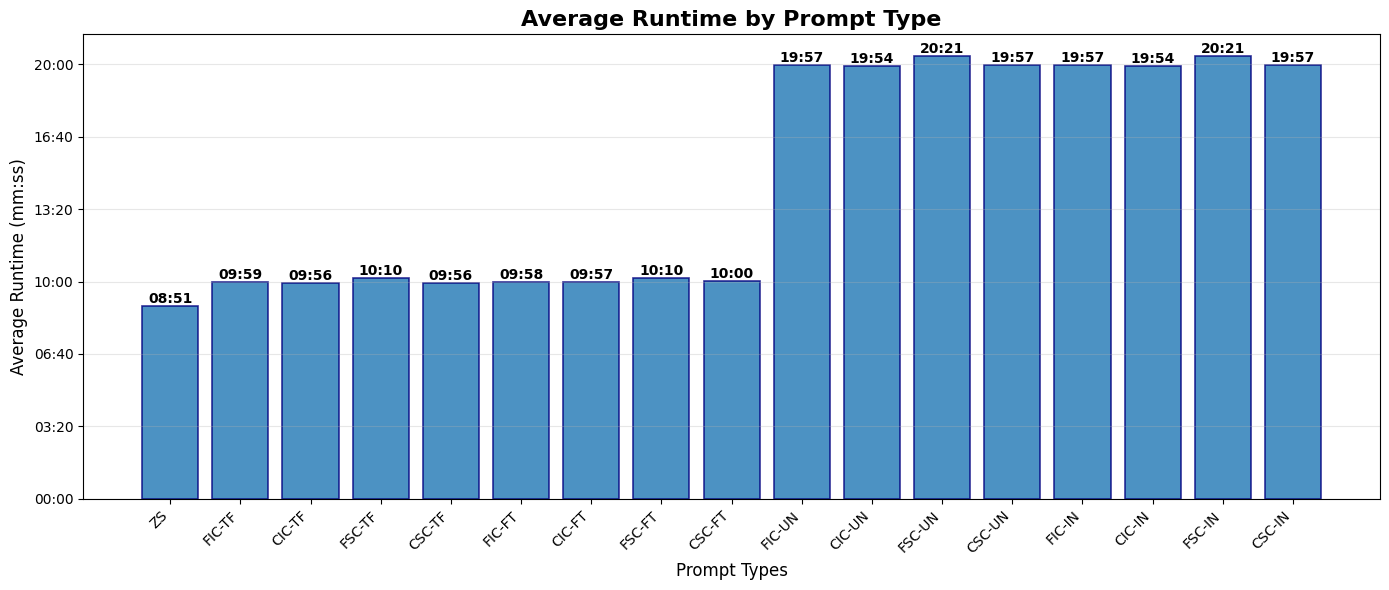

Average Runtime Datset D6 table & figure


Prompt Types,Average Runtime (mm:ss)
ZS,08:29
FIC-TF,09:39
CIC-TF,09:35
FSC-TF,09:46
CSC-TF,10:51
FIC-FT,09:41
CIC-FT,09:37
FSC-FT,09:45
CSC-FT,10:43
FIC-UN,19:21


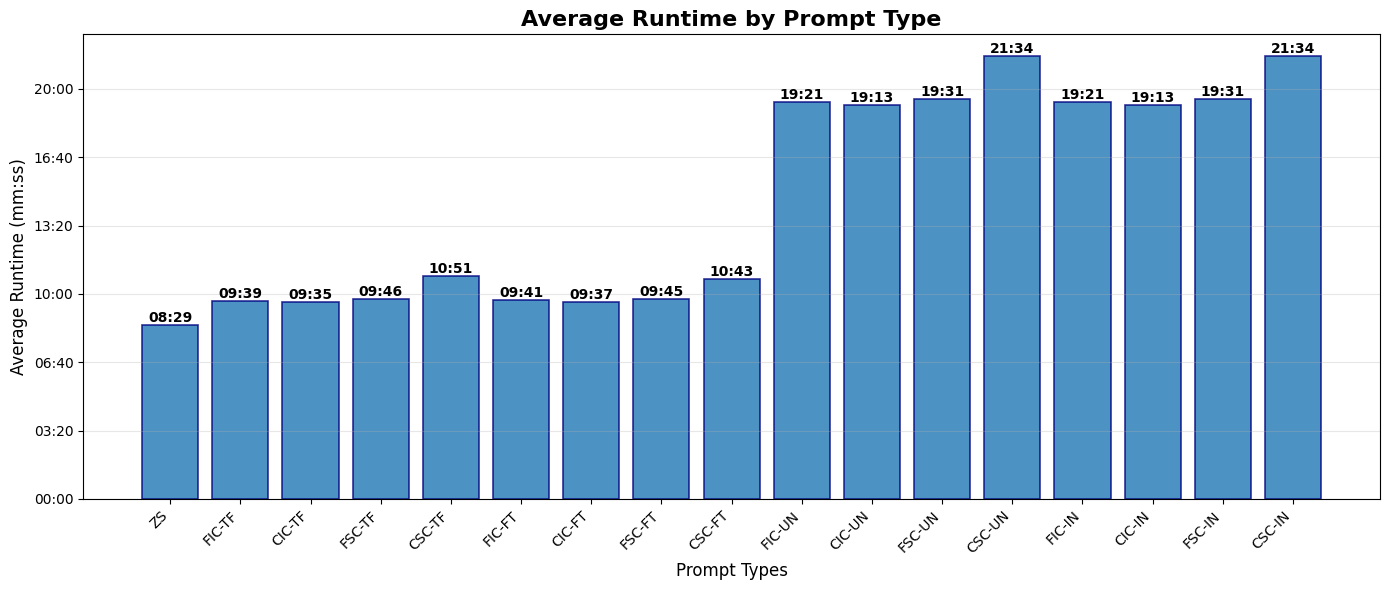

Average Runtime Datset D7 table & figure


Prompt Types,Average Runtime (mm:ss)
ZS,13:25
FIC-TF,16:52
CIC-TF,15:10
FSC-TF,16:20
CSC-TF,23:27
FIC-FT,16:55
CIC-FT,15:11
FSC-FT,16:22
CSC-FT,23:32
FIC-UN,33:48


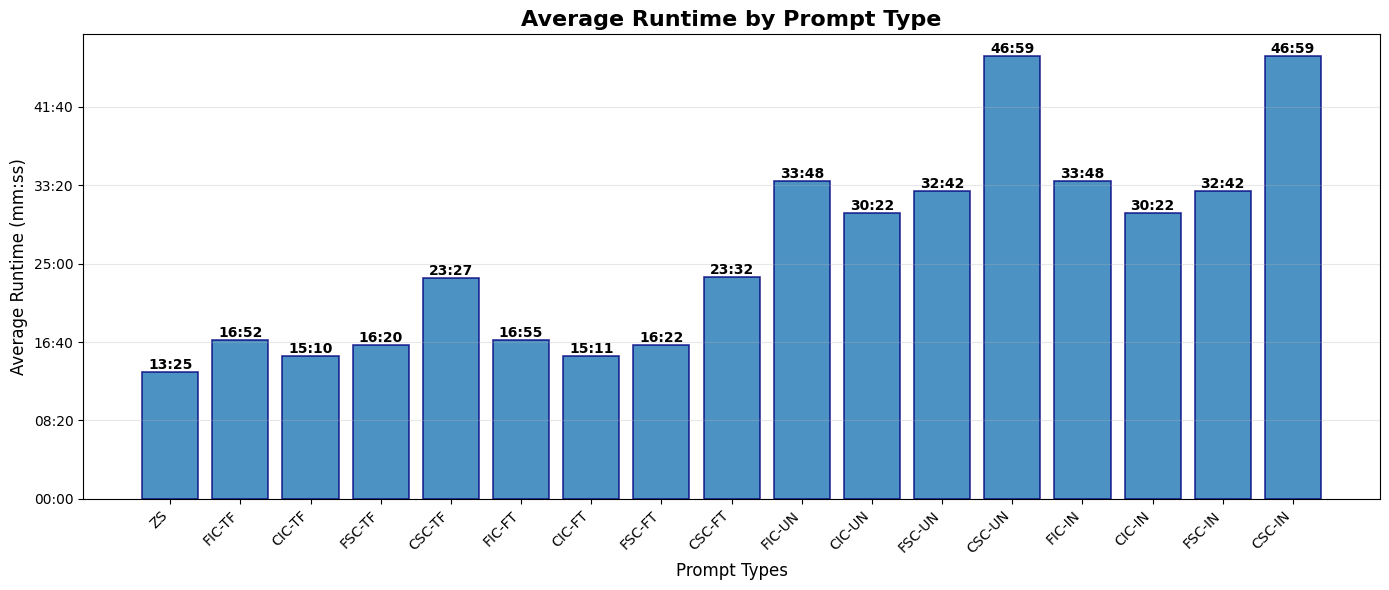

Average Runtime Datset D8 table & figure


Prompt Types,Average Runtime (mm:ss)
ZS,11:28
FIC-TF,12:57
CIC-TF,13:00
FSC-TF,12:55
CSC-TF,12:57
FIC-FT,12:58
CIC-FT,13:02
FSC-FT,12:54
CSC-FT,13:00
FIC-UN,25:56


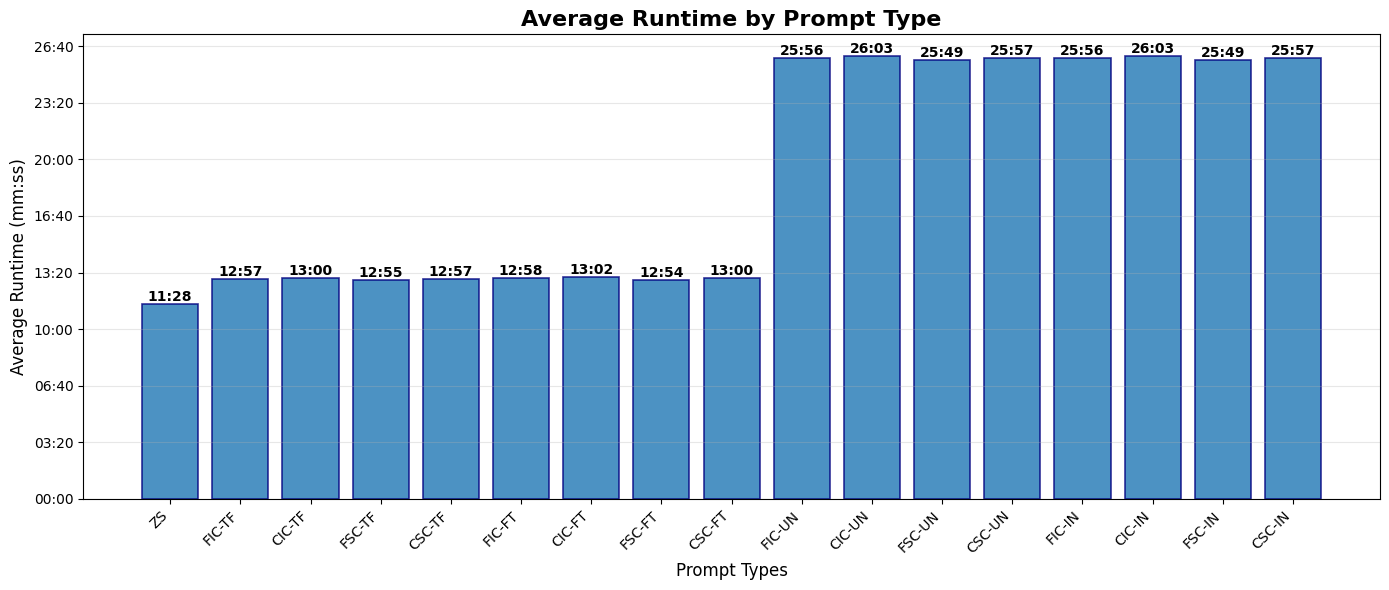

In [9]:
print("RUNTIME")

results_extraction_runtime(candidate_pairs)
